In [771]:
import os
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split
housing = fetch_california_housing()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.98, random_state=2)
XR, yR = make_regression(n_samples=100, n_features=2, noise=0, random_state=5)
X_train2, X_test2, y_train2, y_test2 = train_test_split(XR, yR, test_size=0.20, random_state=2)

def normalize_dataset(X):
    return tf.keras.utils.normalize(X)



(80, 2) * (2, 10) + (1,) = (80, 10)
(80, 2) * (2, 10) + (1,) = (80, 10)
(80, 10) * (10, 10) + (1,) = (80, 10)
(80, 10) * (10, 10) + (1,) = (80, 10)
(80, 10) * (10, 10) + (1,) = (80, 10)
(80, 10) * (10, 10) + (1,) = (80, 10)
(80, 10) * (10, 10) + (1,) = (80, 10)
(80, 10) * (10, 10) + (1,) = (80, 10)
(80, 10) * (10, 2) + (1,) = (80, 2)
(80, 10) * (10, 2) + (1,) = (80, 2)
tf.Tensor(
[ 69.56694568  17.19135469  96.0420141  -70.16867496 -26.92800646
 -34.73775212   4.6910254  -73.56922089 -73.25846141   9.44586459
 -15.02128623  96.13458883 -65.59897761  19.74838514  91.98864978
  91.7044032  -67.36301497  21.60359383  93.99794547   4.15596841
  96.07329673 -73.22313772 -59.27322556  46.14094329  23.86133691
  32.36720891 -20.57335773 -48.29764592  82.53062998 -73.28970907
  36.50737764   9.22310813 -17.45424028  70.71591045 -69.31643781
  34.1129163   81.78233829   9.05576944  52.31690882 -70.74228261
 -14.96648567 -35.03478189  92.48269042  31.52461968  -5.87915279
 -74.05744119  42.93086

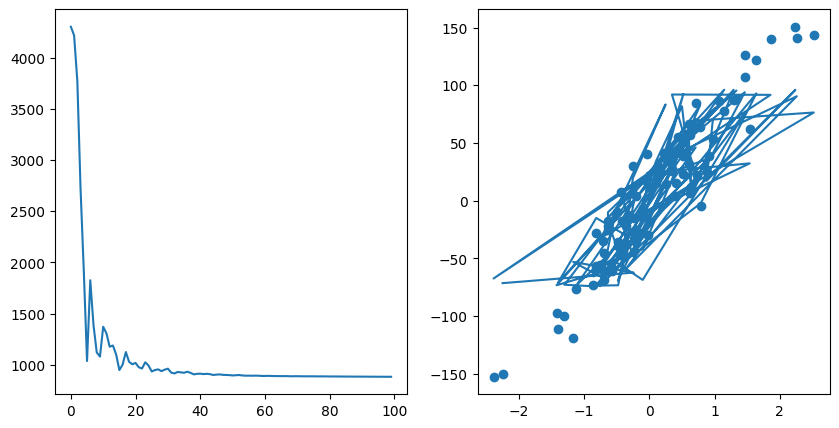

In [961]:
class Layer(tf.Module):
    def __init__(self, neurons=30, activation=tf.identity):
        self.neurons = neurons
        self.activation = activation
        self.build = False
        self.normalized = False

    @tf.function(reduce_retracing=True)
    def xavier_init(self, shape):
        in_dim, out_dim = shape
        xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
        weight_vals = tf.cast(tf.random.uniform(shape=(in_dim, out_dim), 
                                        minval=-xavier_lim, maxval=xavier_lim, seed=22, dtype=tf.float32), dtype=tf.double)
        return weight_vals

    @tf.function
    def __call__(self, X):
        if not self.build:
            n_features = X.shape[1]
            self.weights = tf.Variable(self.xavier_init(shape=(n_features, self.neurons)), name="Weights", dtype=tf.double, trainable=True )
            self.bias = tf.Variable(tf.zeros(shape=1, dtype=tf.double), name="Bias", dtype=tf.double, trainable=True )
            self.build = True

        z = tf.add(tf.matmul(X, self.weights), self.bias)

        print(X.shape,"*",self.weights.shape,"+",self.bias.shape, "=", z.shape)
        return self.activation(z)

    

class MLPLinearRegressor(tf.Module):
    def __init__(self, layers, X, y, lr=0.001, epochs=10):
        self.layers = layers
        self.lr = lr
        self.epochs = epochs
        self.loaded = False
        self.X = X 
        self.XN = normalize_dataset(X)
        self.y = y
        self.optimizer = tf.keras.optimizers.Adam(lr)
        self.mse = tf.keras.metrics.MeanSquaredError()
        self.accuracy = tf.keras.metrics.MeanSquaredLogarithmicError()
        self.precision = tf.keras.metrics.Precision()
        self.loss_history = [e for e in range(epochs)]

    @tf.function(reduce_retracing=True)
    def accuracy_rrsse(self, predicted):
        return tf.divide(tf.sqrt(
            tf.divide(
                tf.reduce_sum(tf.square(tf.abs((tf.subtract(predicted, self.y))))),
                tf.reduce_sum(tf.square(tf.abs((tf.subtract(tf.reduce_mean(self.y), predicted)))))
            )), predicted.shape[0]
        )

    @tf.function(reduce_retracing=True)
    def loss(self, predicted):
        return tf.losses.mean_squared_error(self.y, predicted)

    @tf.function(reduce_retracing=True)
    def calc_metrics(self):
        self.acc_rrsse = self.accuracy_rrsse(self.predicted)
        self.accuracy.update_state(self.y, self.predicted)
        self.precision.update_state(self.y, self.predicted)
        self.mse.update_state(self.y, self.predicted)

    @tf.function(reduce_retracing=True)
    def train_step(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

    def train(self):
        self.weights = model.train_step(self.XN)
        self.vars = [self.layers[0].weights, self.layers[1].weights, self.layers[2].weights,self.layers[3].weights,self.layers[4].weights, self.layers[0].bias, self.layers[1].bias, self.layers[2].bias,self.layers[3].bias,self.layers[4].bias]

        for e in range(self.epochs):
            with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
                self.weights = model.train_step(self.XN)
                self.predicted = tf.reduce_sum(tf.add(tf.add(tf.matmul(self.XN, tf.transpose(self.weights)), self.layers[len(self.layers)-1].bias), self.lr), axis=0)
                loss = self.loss(self.predicted)
                self.loss_history[e] = loss.numpy()
                
            grads = tape.gradient(loss, self.vars)
            self.optimizer.apply_gradients(zip(grads, self.vars)) 
            #self.weights = self.train_step(self.XN)
        print(self.predicted)

model = MLPLinearRegressor([
    Layer(neurons=10,activation=tf.nn.relu),
    Layer(neurons=10,),
    Layer(neurons=10,activation=tf.nn.relu),
    Layer(neurons=10,),
    Layer(neurons=2, activation=tf.identity)
],X_train2, tf.squeeze(y_train2), lr=0.1, epochs=100)


model.train()
model.calc_metrics()


print("MeanSquaredError: ", model.mse.result().numpy())
print("Keras Accuracy: ", model.accuracy.result().numpy())
print("Keras Precision: ", model.precision.result().numpy())


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot([e for e in range(model.epochs)], model.loss_history)

ax[1].scatter(X_train2[:, 0], y_train2[:])
ax[1].plot(X_train2[:, 0], model.predicted[:])
plt.show()

